In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('../../utils/')
from layers import wide_resnet, wide_resnet_snorm
import tfops

In [3]:
#
import tensorflow as tf

# tf.enable_eager_execution()

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
import tensorflow_probability as tfp
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors


In [4]:
nc = 32
nsize = 1000
lins = np.random.normal(size=nsize*nc**3).reshape(nsize, nc, nc, nc)
fins = lins**2

In [5]:
sys.path.append('../../utils/flowpm/')
import tfpmconfig, tfpm
import tfpmfuncs as tfpf
import tfpmfuncs
sys.path.append('../../utils/')
import tools


In [6]:
bs, nc = 100, 32
config = tfpmconfig.Config(bs=bs, nc=nc)
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

# path = '../../data/toy/L0100_N0032/S{:04d}/'
path = '../../../galmodel/data/toy/L0100_N0032/S{:04d}/'
seed = 0 
s = np.load(path.format(seed) + 's.npy')
d = np.load(path.format(seed) + 'd.npy')
p = np.load(path.format(seed) + 'p.npy')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
lins, fins, finsample = [], [], []
for seed in range(1000):
    lins.append(np.load(path.format(seed)+'s.npy'))
    fins.append(np.load(path.format(seed)+'d.npy'))
    finsample.append(np.load(path.format(seed)+'p.npy'))

lins = np.array(lins)
fins = np.array(fins)
finsample = np.array(finsample)

# Check

In [171]:
def wide_resnetlocal(inputs, depth,
                kernel_size=3, stride=1,
                keep_prob=None,
                #activation_fn=tf.nn.leaky_relu,                                                                                                                                                                                  
                activation_fn=tf.nn.relu,
                is_training=True,
                      outputs_collections=None, scope=None, normwt=0.9, resonly=False):
    """                                                                                                                                                                                                                           
    Wide residual units as advocated in arXiv:1605.07146                                                                                                                                                                          
    Adapted from slim implementation of residual networks                                                                                                                                                                         
    Impose Lipschitz control on the kernels by dividing them with                                                                                                                                                                 
    their spectral norm. Batch norm is replaced by actnorm                                                                                                                                                                        
    """
    depth_residual = 2 * depth
    depth_in = slim.utils.last_dimension(inputs.get_shape(), min_rank=4)
    size_in = inputs.get_shape().as_list()[1]



    with tf.variable_scope(scope, 'wide_resnet', [inputs]) as sc:
        with slim.arg_scope([tfops.actnorm3d, slim.dropout, slim.batch_norm],
                            is_training=is_training):
            with slim.arg_scope([slim.conv3d],
                                kernel_size=kernel_size,
                                stride=stride):

                #preact = tfops.actnorm3d(inputs, scope='preact')                                                                                                                                                                 
                #preact = slim.batch_norm(                                                                                                                                                                                        
                #    inputs, activation_fn=activation_fn, scope='preact')                                                                                                                                                         
                preact = tf.nn.leaky_relu(inputs)
#                 preact = tf.identity(inputs)
                if activation_fn is not None: preact = activation_fn(preact)

                if depth_in != depth:
                    shortcut = slim.conv3d(preact, depth)
                else:
                    shortcut = preact

                residual = slim.conv3d(preact, depth_residual, )

                if keep_prob is not None:
                    residual = slim.dropout(residual, keep_prob=keep_prob)

                residual = slim.conv3d(residual, depth)

                return shortcut, residual

#                 return slim.utils.collect_named_outputs(outputs_collections,
#                                                         sc.name,
#                                                         output)



In [27]:
tf.reset_default_graph()

xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='output')
# short, net = wide_resnetlocal(xx, 1)
# out = short + net
# print(net, xx, yy)
# loss = tf.reduce_mean(tf.square(out-yy))

net = slim.conv3d(xx, 2, 3)
net = tf.nn.leaky_relu(net)
res = slim.conv3d(net, 1, 3)
res = tf.nn.leaky_relu(res)

out = xx + res
loss = tf.nn.l2_loss(out-yy)


lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

np.random.seed(100)
for i in range(2000):
    inds = np.random.randint(0, data_size, batch_size)
    x = np.expand_dims(lins[inds], -1)
    y = np.expand_dims(fins[inds], -1)
#     y = x.copy()
    y *= y
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.01})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

pred = sess.run(out, feed_dict={xx:x, yy:y, lr:0.001})
        

55508656.0
35071736.0
30978884.0
29277058.0
28775574.0
28781802.0
29094736.0


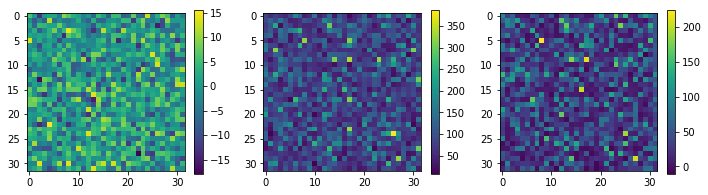

In [28]:
xt = x[0:1, ...].copy()
yt = y[0:1, ...].copy()
pt = pred[0:1, ...].copy()



fig, ax = plt.subplots(1, 3, figsize = (12, 3))
im = ax[0].imshow(np.squeeze(xt).sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(yt).sum(axis=0))
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pt).sum(axis=0))
plt.colorbar(im, ax=ax[2])


In [33]:
x0 = pt.copy()
xf = pt.copy()

for i in range(10):
    xi = sess.run(res, feed_dict={xx:xf, yy:pt})
    xf = pt - xi

Text(0.5, 1.0, 'Estimated Inverse')

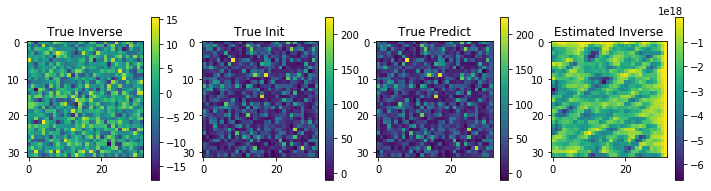

In [34]:
fig, ax = plt.subplots(1, 4, figsize = (12, 3))
im = ax[0].imshow(xt[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True Inverse')

im = ax[1].imshow(x0[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('True Init')

im = ax[2].imshow(pt[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('True Predict')

im = ax[3].imshow(xf[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[3])
ax[3].set_title('Estimated Inverse')


In [ ]:
# x0 = pt.copy()
# xf = pt.copy()

# for i in range(2000):
#     xi = sess.run(net, feed_dict={xx:xf, yy:pt})
# #     xf2 = pt2 - xi
#     xf = xi/np.linalg.norm(xi)
    
    
# print(np.linalg.norm(xf))

In [177]:
# plt.imshow(xf[0,...,0].sum(axis=0))

### Specnorm

In [6]:
def wide_resnet_snormlocal(inputs, depth,
                kernel_size=3, stride=1,
                keep_prob=None,
                activation_fn=tf.nn.leaky_relu,                                                                                                                                                                                  
#                 activation_fn=tf.identity,
                is_training=True,
                      outputs_collections=None, scope=None, normwt=0.9, resonly=False):
    """                                                                                                                                                                                                                           
    Wide residual units as advocated in arXiv:1605.07146                                                                                                                                                                          
    Adapted from slim implementation of residual networks                                                                                                                                                                         
    Impose Lipschitz control on the kernels by dividing them with                                                                                                                                                                 
    their spectral norm. Batch norm is replaced by actnorm                                                                                                                                                                        
    """
    depth_residual = 2 * depth
    depth_in = slim.utils.last_dimension(inputs.get_shape(), min_rank=4)
    size_in = inputs.get_shape().as_list()[1]



    with tf.variable_scope(scope, 'wide_resnet', [inputs]) as sc:
        with slim.arg_scope([tfops.actnorm3d, slim.dropout, slim.batch_norm],
                            is_training=is_training):
            with slim.arg_scope([tfops.specnormconv3d],
                                kernel_size=kernel_size,
                                stride=stride):

                #preact = tfops.actnorm3d(inputs, scope='preact')                                                                                                                                                                 
                #preact = slim.batch_norm(                                                                                                                                                                                        
                #    inputs, activation_fn=activation_fn, scope='preact')                                                                                                                                                         
                preact = tf.nn.leaky_relu(inputs)
#                 preact = tf.identity(inputs)
                if activation_fn is not None: preact = activation_fn(preact)

                shortcut = preact

                residual = tfops.specnormconv3d(preact, depth_residual, name='res1', normwt=normwt)

                if keep_prob is not None:
                    residual = slim.dropout(residual, keep_prob=keep_prob)

                residual = tfops.specnormconv3d(residual, depth, name='res2', normwt=normwt)

                return shortcut, residual

#                 return slim.utils.collect_named_outputs(outputs_collections,
#                                                         sc.name,
#                                                         output)



In [110]:
tf.reset_default_graph()

normwt = 0.8

xx2 = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='input')
yy2 = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='output')
short2, res2 = wide_resnet_snormlocal(xx2, 1, normwt=.7)
out2 = res2 + xx2

# net2 = tfops.specnormconv3d(xx2, 2, name='res1', normwt=normwt)
# net2 = tf.nn.leaky_relu(net2)
# res2 = tfops.specnormconv3d(net2, 4, name='res2', normwt=normwt)
# res2 = tf.nn.leaky_relu(res2)
# res2 = tfops.specnormconv3d(net2, 2, name='res3', normwt=normwt)
# res2 = tf.nn.leaky_relu(res2)
# res2 = tfops.specnormconv3d(res2, 1, name='res4', normwt=normwt)
# res2 = tf.nn.leaky_relu(res2)

out2 = xx2 + res2
loss2 = tf.nn.l2_loss(out2-yy2)
    
optimizer2 = tf.train.AdamOptimizer(learning_rate=0.1)
train_op2 = optimizer2.minimize(loss2)

sess2 = tf.Session()
sess2.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

np.random.seed(100)
for i in range(1000):
    inds = np.random.randint(0, data_size, batch_size)
    x = np.expand_dims(lins[inds], -1)
    y = np.expand_dims(fins[inds], -1)
#     y = x.copy()
    y *= y
    l,_= sess2.run([loss2, train_op2], feed_dict={xx2:x, yy2:y})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

pred2 = sess2.run(out2, feed_dict={xx2:x, yy2:y})
        

../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'


56508960.0
50480812.0
49770630.0
48895228.0


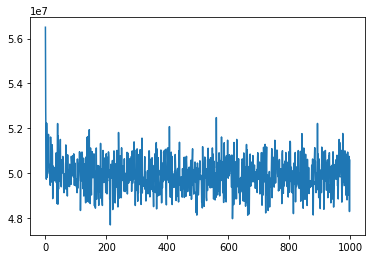

In [111]:
plot(losses)

Text(0.5, 1.0, 'Learned Output')

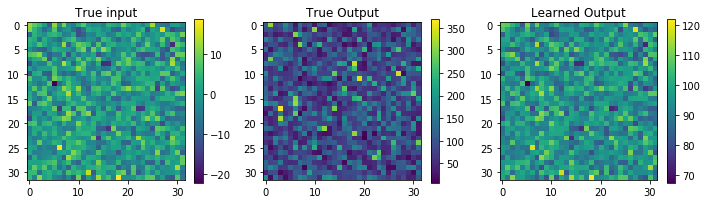

In [112]:
xt2 = x[0:1, ...].copy()
yt2 = y[0:1, ...].copy()
pt2 = pred2[0:1, ...].copy()



fig, ax = plt.subplots(1, 3, figsize = (12, 3))
im = ax[0].imshow(np.squeeze(xt2).sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True input')
im = ax[1].imshow(np.squeeze(yt2).sum(axis=0))
ax[1].set_title('True Output')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pt2).sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Learned Output')


In [113]:
x02 = pt2.copy()
xf2 = pt2.copy()
err = []
for i in range(100):
    xi = sess2.run(res2, feed_dict={xx2:xf2, yy2:pt2})
    xf2 = pt2 - xi
    err.append(sum((xt2 - xf2)**2))


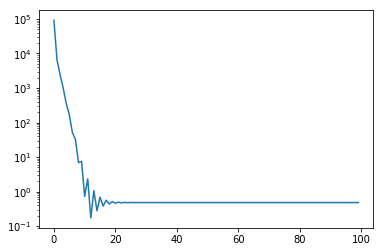

In [114]:
plt.plot(err[:])
plt.yscale('log')
# plt.xlim(0, 30)

Text(0.5, 1.0, 'Estimated Inverse')

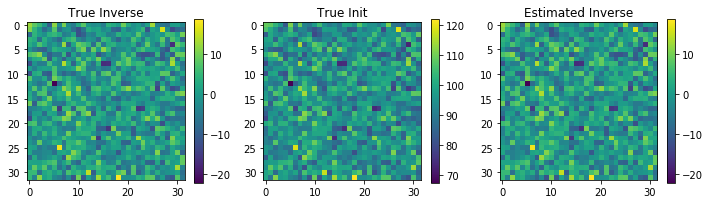

In [115]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
im = ax[0].imshow(xt2[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True Inverse')

im = ax[1].imshow(x02[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('True Init')


im = ax[2].imshow(xf2[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Estimated Inverse')


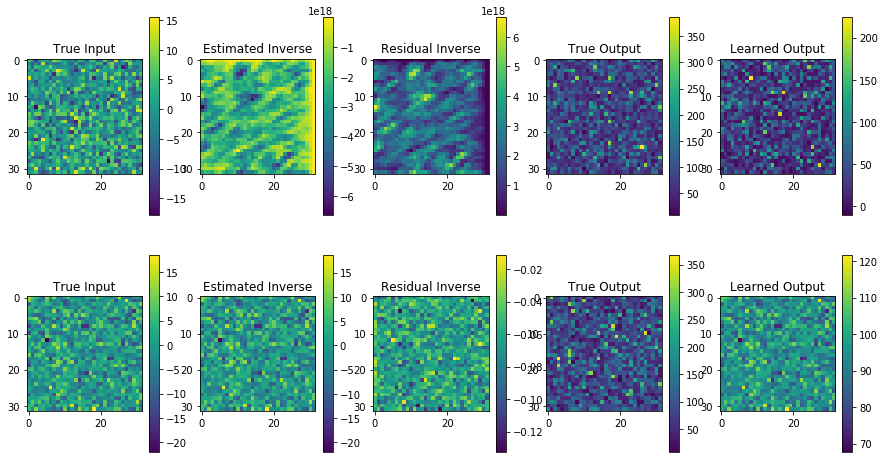

In [116]:
fig, axar = plt.subplots(2, 5, figsize = (15, 8))


def thisplot(axis, mat, title):
    
    im = axis.imshow(mat[0,...,0].sum(axis=0))
    plt.colorbar(im, ax=axis)
    axis.set_title(title)
    

ax = axar[0]

axis, mat, title = ax[0], xt, 'True Input'
thisplot(axis, mat, title)

axis, mat, title = ax[1], xf, 'Estimated Inverse'
thisplot(axis, mat, title)

axis, mat, title = ax[2], xt-xf, 'Residual Inverse'
thisplot(axis, mat, title)

axis, mat, title = ax[3], yt, 'True Output'
thisplot(axis, mat, title)

axis, mat, title = ax[4], pt, 'Learned Output'
thisplot(axis, mat, title)

ax = axar[1]

axis, mat, title = ax[0], xt2, 'True Input'
thisplot(axis, mat, title)

axis, mat, title = ax[1], xf2, 'Estimated Inverse'
thisplot(axis, mat, title)

axis, mat, title = ax[2], xt2-xf2, 'Residual Inverse'
thisplot(axis, mat, title)

axis, mat, title = ax[3], yt2, 'True Output'
thisplot(axis, mat, title)

axis, mat, title = ax[4], pt2, 'Learned Output'
thisplot(axis, mat, title)


In [95]:
# x02 = pt2.copy()
# xf2 = pt2.copy()

# for i in range(2000):
#     xi = sess2.run(net2, feed_dict={xx2:xf2, yy2:pt2})
# #     xf2 = pt2 - xi
#     xf2 = xi/np.linalg.norm(xi)
    
# print(np.linalg.norm(xf2))

In [71]:
# def poweriter(mat):
#     u = np.random.normal(size=mat.shape[-1])
#     for i in range(100):
#         v = np.matmul(u, mat.T)
#         v = v/np.linalg.norm(v)
#         u = np.matmul(v, mat)
#         u = u/np.linalg.norm(u)

#     return np.matmul(np.matmul(v, mat), np.transpose(u))





In [87]:
# import tensorflow as tf
# import numpy as np

# def SVD_Conv_Tensor(conv, inp_shape):
#   """ Find the singular values of the linear transformation
#   corresponding to the convolution represented by conv on
#   an n x n x depth input. """
#   conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex64)
#   conv_shape = conv.get_shape().as_list()
#   padding = tf.constant([[0, 0], [0, 0],
#                          [0, inp_shape[0] - conv_shape[0]],
#                          [0, inp_shape[1] - conv_shape[1]]])
#   transform_coeff = tf.fft2d(tf.pad(conv_tr, padding))
#   singular_values = tf.svd(tf.transpose(transform_coeff, perm = [2, 3, 0, 1]),
#                            compute_uv=False)
#   return singular_values


# Clip method

In [81]:
def Clip_OperatorNorm(conv, inp_shape, clip_to):
    conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex64)
    conv_shape = conv.get_shape().as_list()
    padding = tf.constant([[0, 0], [0, 0],
                         [0, inp_shape[0] - conv_shape[0]],
                         [0, inp_shape[1] - conv_shape[1]]])
    transform_coeff = tf.fft2d(tf.pad(conv_tr, padding))
    D, U, V = tf.svd(tf.transpose(transform_coeff, perm = [2, 3, 0, 1]))
    norm = tf.reduce_max(D)
    D_clipped = tf.cast(tf.minimum(D, clip_to), tf.complex64)
    clipped_coeff = tf.matmul(U, tf.matmul(tf.linalg.diag(D_clipped),
                                         V, adjoint_b=True))
    clipped_conv_padded = tf.real(tf.ifft2d(
      tf.transpose(clipped_coeff, perm=[2, 3, 0, 1])))
    return tf.slice(tf.transpose(clipped_conv_padded, perm=[2, 3, 0, 1]),
                  [0] * len(conv_shape), conv_shape), norm

def spec_norm_constraint(w):
    return Clip_OperatorNorm(w, inp_shape=[3,3], clip_to=0.9)[0]





# def g(in_net):
#   net = tf.layers.conv3d(in_net, 32, 3, padding='same', kernel_constraint=spec_norm_constraint, activation=tf.nn.leaky_relu)
#   net = tf.layers.conv3d(net, 16, 3, padding='same', kernel_constraint=spec_norm_constraint, activation=tf.nn.leaky_relu)
#   return net

# tf.reset_default_graph()
# x = tf.placeholder(shape=[None, 32, 32, 32, 1], dtype=tf.float32)
# y = tf.placeholder(shape=[None, 32, 32, 32, 1], dtype=tf.float32)

# res = g(x)
# out = x + res

# loss = tf.nn.l2_loss(y  - out)
# opt = tf.train.AdamOptimizer(learning_rate=0.001)
# opt_op = opt.minimize(loss)

In [24]:
def Clip_OperatorNorm3D(conv, inp_shape, clip_to):
    conv_tr = tf.cast(tf.transpose(conv, perm=[3, 4, 0, 1, 2]), tf.complex64)
    conv_shape = conv.get_shape().as_list()
    print(conv_shape)
    padding = tf.constant([[0, 0], [0, 0],
                         [0, inp_shape[0] - conv_shape[0]],
                         [0, inp_shape[1] - conv_shape[1]],
                            [0, inp_shape[2] - conv_shape[2]]])
    transform_coeff = tf.fft3d(tf.pad(conv_tr, padding))
    D, U, V = tf.svd(tf.transpose(transform_coeff, perm = [3, 4, 0, 1, 2]))
    norm = tf.reduce_max(D)
    D_clipped = tf.cast(tf.minimum(D, clip_to), tf.complex64)
    clipped_coeff = tf.matmul(U, tf.matmul(tf.linalg.diag(D_clipped),
                                         V, adjoint_b=True))
    clipped_conv_padded = tf.real(tf.ifft3d(
      tf.transpose(clipped_coeff, perm=[3, 4, 0, 1, 2])))
    return tf.slice(tf.transpose(clipped_conv_padded, perm=[3, 4, 0, 1, 2]),
                  [0] * len(conv_shape), conv_shape), norm

def spec_norm_constraint3D(w):
    print('w :', w)
    clip = Clip_OperatorNorm3D(w, inp_shape=[3,3,3], clip_to=0.9)[0]
    print('clip :', clip)
    return clip

In [25]:
def wide_resnet_cliplocal(inputs, depth,
                kernel_size=3, stride=1,
                keep_prob=None,
                #activation_fn=tf.nn.leaky_relu,                                                                                                                                                                                  
                activation_fn=tf.nn.relu,
                is_training=True,
                      outputs_collections=None, scope=None, normwt=0.9, resonly=False):
#     """                                                                                                                                                                                                                           
#     Wide residual units as advocated in arXiv:1605.07146                                                                                                                                                                          
#     Adapted from slim implementation of residual networks                                                                                                                                                                         
#     Impose Lipschitz control on the kernels by dividing them with                                                                                                                                                                 
#     their spectral norm. Batch norm is replaced by actnorm                                                                                                                                                                        
#     """
#     depth_residual = 4 * depth
#     depth_in = slim.utils.last_dimension(inputs.get_shape(), min_rank=4)
#     size_in = inputs.get_shape().as_list()[1]



#     with tf.variable_scope(scope, 'wide_resnet', [inputs]) as sc:
#         with slim.arg_scope([tfops.actnorm3d, slim.dropout, slim.batch_norm],
#                             is_training=is_training):
# #             with slim.arg_scope([tf.layers.conv3d],
# #                                 kernel_size=kernel_size,
# #                                 stride=stride):

    preact = tf.nn.leaky_relu(inputs)
#                 preact = tf.identity(inputs)
#             if activation_fn is not None: preact = activation_fn(preact)

    shortcut = preact
    residual = tf.layers.conv3d(preact, 2*depth, 3, 
                    padding='same', kernel_constraint=spec_norm_constraint3D, activation=tf.nn.leaky_relu)
#                residual = tfops.specnormconv3d(preact, depth_residual, name='res1', normwt=normwt)

    if keep_prob is not None:
        residual = slim.dropout(residual, keep_prob=keep_prob)

    residual = tf.layers.conv3d(preact, depth, 3, 
                    padding='same', kernel_constraint=spec_norm_constraint3D, activation=tf.nn.leaky_relu)

    return shortcut, residual




In [26]:
tf.reset_default_graph()


xx3 = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='input')
yy3 = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='output')
# short3, net3 = wide_resnet_cliplocal(xx3, 1)
# out3 = net3 + short3
# loss3 = tf.reduce_mean(tf.square(out3-yy3))
out3 = tf.layers.conv3d(xx3, 1, 3, 
                    padding='same', kernel_constraint=spec_norm_constraint3D, activation=tf.nn.leaky_relu)
print('out3 : ',out3)
loss3 = tf.reduce_mean(out3)
    
optimizer3 = tf.train.AdamOptimizer(learning_rate=0.1)
train_op3 = optimizer3.minimize(loss3)

sess3 = tf.Session()
sess3.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

np.random.seed(100)
for i in range(2000):
    inds = np.random.randint(0, data_size, batch_size)
    x = np.expand_dims(lins[inds], -1)
    y = np.expand_dims(fins[inds], -1)
#     y = x.copy()
    y *= y
    l,_= sess3.run([loss3, train_op3], feed_dict={xx3:x, yy3:y})
#     l= sess3.run(loss3, feed_dict={xx3:x, yy3:y})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

pred3 = sess3.run(net3, feed_dict={xx3:x, yy3:y})
        

out3 :  Tensor("conv3d/LeakyRelu:0", shape=(?, 32, 32, 32, 1), dtype=float32)
w : <tf.Variable 'conv3d/kernel:0' shape=(3, 3, 3, 1, 1) dtype=float32_ref>
[3, 3, 3, 1, 1]
clip : Tensor("Adam/update_conv3d/kernel/Slice:0", shape=(3, 3, 3, 1, 1), dtype=float32)


InvalidArgumentError: Expected size[1] in [0, 1], but got 3
	 [[{{node Adam/update_conv3d/kernel/Slice}} = Slice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@Adam/update_conv3d/kernel/Assign"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Adam/update_conv3d/kernel/transpose_3, Adam/update_conv3d/kernel/Slice/begin, Adam/update_conv3d/kernel/Slice/size)]]
	 [[{{node Adam/update_conv3d/kernel/Assign/_26}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_106_Adam/update_conv3d/kernel/Assign", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'Adam/update_conv3d/kernel/Slice', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/chmodi/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-5af7fe4ece34>", line 15, in <module>
    train_op3 = optimizer3.minimize(loss3)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/optimizer.py", line 411, in minimize
    name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/optimizer.py", line 608, in apply_gradients
    update_ops.append(processor.update_op(self, grad))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/optimizer.py", line 118, in update_op
    return self._v.assign(self._v.constraint(self._v))
  File "<ipython-input-24-64f4ddaf2d87>", line 22, in spec_norm_constraint3D
    clip = Clip_OperatorNorm3D(w, inp_shape=[3,3,3], clip_to=0.9)[0]
  File "<ipython-input-24-64f4ddaf2d87>", line 18, in Clip_OperatorNorm3D
    [0] * len(conv_shape), conv_shape), norm
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py", line 578, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 7280, in _slice
    "Slice", input=input, begin=begin, size=size, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Expected size[1] in [0, 1], but got 3
	 [[{{node Adam/update_conv3d/kernel/Slice}} = Slice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@Adam/update_conv3d/kernel/Assign"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Adam/update_conv3d/kernel/transpose_3, Adam/update_conv3d/kernel/Slice/begin, Adam/update_conv3d/kernel/Slice/size)]]
	 [[{{node Adam/update_conv3d/kernel/Assign/_26}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_106_Adam/update_conv3d/kernel/Assign", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [11]:
x.shape

(32, 32, 32, 32, 1)